## Define system-specific paths, which variables (swbgt) used in era5, etc

In [1]:

local_var = 'swbgt'
timefreq = 'hourly'

data_path  =    '/Users/lukeaparsons/Documents/Manuscripts/CMIP6_HeatPatterns/data/'

## Import modules for analysis/plotting


In [2]:

import warnings
warnings.filterwarnings('ignore')
import os
import glob
import re
import numpy as np
import xarray as xr
import xesmf as xe
from scipy import stats
from scipy import signal
import time
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.cm as cm
import matplotlib.colors as colors

## Define the global warming factors (gwfs) relative to present (0,1,2,3,4), 
## labor types (here have all 3 but n=2 for loading heavy), and variables to load

In [3]:
gwfs = (0, 1, 2, 3, 4) #these are all global warming factors for loading data, looking at various warming thresholds

LaborTypes = ['light','medium','heavy']

n = 2 #set labor type: 2 is heavy

variables = ['12hrworkday',
             'hottest_hour',
             'coolest_hour',
             '2ndcoolest_hour',
             '3rdcoolest_hour']

strings_warmingfactors = ['2001_2020_mean',
                         'globalwarming_1C',
                         'globalwarming_2C',
                         'globalwarming_4C'] # note removed laborlost_regridded_countrymaskgrid because only plot of current, 0,1,2,4C

#variable names follow forms such as:
# annual_hours_lost_12hrworkday_2001_2020_mean
# annual_hours_lost_12hrworkday_globalwarming_1C
# annual_hours_lost_12hrworkday_globalwarming_2C
# annual_hours_lost_12hrworkday_globalwarming_3C
# annual_hours_lost_12hrworkday_globalwarming_4C

## loop through loading the labor and productivity loss netcdf files


In [4]:
nc_labor = xr.open_dataset(data_path + 'heavylaborlost_global_populationweighted_annual_hours_lost_mean_present_warming_1_2_3_4_C_grid_05x05.nc')
nc_prod = xr.open_dataset(data_path + 'heavylaborlost_global_populationweighted_annual_productivity2017PPP_lost_mean_present_warming_1_2_3_4_C_grid_05x05.nc')

nc_labor_percapita_gwf0 = xr.open_dataset(data_path + 'hours_lost_annual_heavylabor_sWBGT_ERA5_WattsKjellstromLancetERF_2001_2020.nc')
nc_labor_percapita_gwf1 = xr.open_dataset(data_path + 'hours_lost_annual_heavylabor_sWBGT_ERA5_WattsKjellstromLancetERF_AddtlGlobalWarming_1_C.nc')
nc_labor_percapita_gwf2 = xr.open_dataset(data_path + 'hours_lost_annual_heavylabor_sWBGT_ERA5_WattsKjellstromLancetERF_AddtlGlobalWarming_2_C.nc')
#nc_labor_percapita_gwf3 = xr.open_dataset(data_path + 'hours_lost_annual_heavylabor_sWBGT_ERA5_WattsKjellstromLancetERF_AddtlGlobalWarming_3_C.nc')
nc_labor_percapita_gwf4 = xr.open_dataset(data_path + 'hours_lost_annual_heavylabor_sWBGT_ERA5_WattsKjellstromLancetERF_AddtlGlobalWarming_4_C.nc')

## define grid for regridding country border mask


LON = nc_labor['lon']
LAT = nc_labor['lat']

#ds_out xarray dataset defines a grid structure to be used in regridding function later
ds_out = xr.Dataset({'lat': (LAT),
                     'lon': (LON),
                    }
                   )

## load the country border mask netcdf file and associated csv of country names for the indices, regrid to labor loss grid

In [5]:
#load country names for the spatial mask
f_countrynamesfraction = pd.read_csv (r'/Users/lukeaparsons/Documents/Manuscripts/CMIP6_HeatPatterns/data/Turner_05x05_2015.csv')
countrynames_fraction = f_countrynamesfraction['# COUNTRY']
ncountrynames_fraction = len(countrynames_fraction)
#replace the country names to match the ILO country data used in analysis
countrynames_fraction[countrynames_fraction=='Bosnia+Herzegovina'] =  "Bosnia and Herzegovina"
countrynames_fraction[countrynames_fraction=='Central African Rep.'] =  "Central African Republic"
countrynames_fraction[countrynames_fraction=='Czech Republic'] =  "Czechia"
countrynames_fraction[countrynames_fraction=='Dem.Rep.of the Congo'] =  "Congo  Democratic Republic of the"
countrynames_fraction[countrynames_fraction=='Isl.Rep.of Iran'] =  "Iran  Islamic Republic of"
countrynames_fraction[countrynames_fraction=='Lao Peo.Dem.Rep.'] =  "Lao People's Democratic Republic"
countrynames_fraction[countrynames_fraction=='Libyan Arab Jamahiriya'] =  "Libya"
countrynames_fraction[countrynames_fraction=='Morocco+W.Sahara'] =  "Morocco"
countrynames_fraction[countrynames_fraction=='Dem.Peo.Rep.of Korea'] =  "Korea Democratic People's Republic of"
countrynames_fraction[countrynames_fraction=='Rep.of Korea'] =  "Korea Republic of"
countrynames_fraction[countrynames_fraction=='Russian Fed.'] =  "Russian Federation"
countrynames_fraction[countrynames_fraction=='Swaziland'] =  "Eswatini"
countrynames_fraction[countrynames_fraction=='Syrian Arab Rep.'] =  "Syrian Arab Republic"
countrynames_fraction[countrynames_fraction=='United Rep.of Tanzania'] = "Tanzania  United Republic of"
countrynames_fraction[countrynames_fraction=='United Sts.of America'] = "United States"
countrynames_fraction[countrynames_fraction=='Boliv.Rep.of Venezuela'] = "Venezuela  Bolivarian Republic of"

# Load the country data (e.g., spatial mask for each country)
nc_countries = xr.open_dataset(data_path + 'countryFractions_2010_05x05.nc')
nc_countries = nc_countries.rename({'longitude': 'lon','latitude': 'lat',})
countryfraction = nc_countries['fractionCountry']
regridder = xe.Regridder(countryfraction, ds_out, 'bilinear') # regrid using 'bilinear' interpolation to the dataset (ds_out) grid spatial structure
countryfraction_regridded = regridder(countryfraction)#regrid!
countryfraction_nan = countryfraction.where(countryfraction > 0) #remove all missing values, replace w nan/missing indices
countryfraction = countryfraction.where(countryfraction > 0 , 0) #remove all missing values, replace w zero
print('number of countries in country fraction file is: ',len(countryfraction))
LON_countries = nc_countries['lon']
LAT_countries = nc_countries['lat']
ncountriesfraction,nlat_countries,nlon_countries = countryfraction.shape


number of countries in country fraction file is:  193


## Set inputs for the donut plots so each cell can be more modular

In [6]:
# note these are for 2x2 panel plots with abcd labels, for gwfs of 0124
gwfs_plot = [0,1,2,4]
letterlabels = ['a.','b.','c.','d.']
variables = ['12hrworkday','hottest_hour','coolest_hour','2ndcoolest_hour','3rdcoolest_hour']
timeofday = ['12-Hour Workday','Hottest Hour','Coolest Hour','Second Coolest Hour','Third Coolest Hour']

#now define which variable for plotting country-level losses (12 hottest hours, coolest hour, etc.)
variableindex = 0
variable = variables[variableindex]

## Donut plot of top 10 countries with working age-population weighted losses
### (note modular so can choose the variable index!)

GWF: 0 C: 228 Billion Hours
GWF: 1 C: 362 Billion Hours
GWF: 2 C: 547 Billion Hours
GWF: 4 C: 1091 Billion Hours


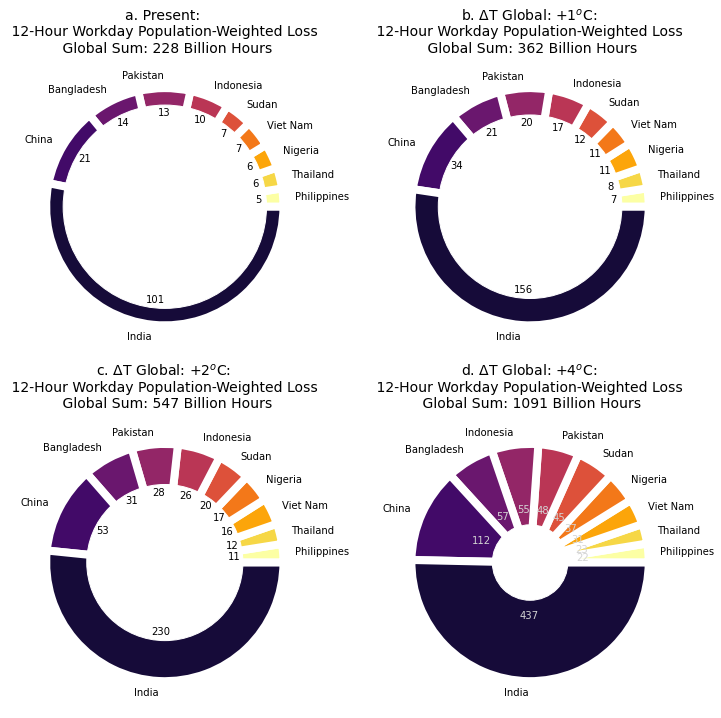

In [7]:
#nc_prod['annual_productivity_lost_'+str(variable)+'_'+str(gwf)]

fig = plt.figure(figsize=(12,12))

if variableindex == 0:
    MaxAmount = 1.6e3
else:
    MaxAmount = 200

for gi,gwf in enumerate(gwfs_plot):

    country_sum_hourslost = np.zeros([len(countrynames_fraction)])
    for countryindex,country in countrynames_fraction.items():
        #print(countrynames_fraction[countryindex])
        country_sum_hourslost[countryindex] = (countryfraction_nan[countryindex,:,:] * nc_labor['annual_hours_lost_'+str(variable)+'_'+str(strings_warmingfactors[gi])]).sum(dim=('lat','lon')).values
    country_sum_hourslost_sortindex = np.argsort(country_sum_hourslost)
    countrynames_fraction_sortedbywagelost = countrynames_fraction[country_sum_hourslost_sortindex]
    
    ax = plt.subplot(2,2,gi+1)
    
    # try a donut plot
    colors_donuts = plt.cm.inferno_r(np.linspace(0,1,1+len(countrynames_fraction_sortedbywagelost[183:194])))
    names = countrynames_fraction_sortedbywagelost[183:194]
    size = country_sum_hourslost[country_sum_hourslost_sortindex][183:194]/1e9
    def autopct_format(size):
        def my_format(pct):
            total = sum(size)
            val = int(round(pct*total/100.0))
            return '{v:d}'.format(v=val)
        return my_format
    
    # Create a circle at the center of the plot
    TopCountrySum = np.nansum(country_sum_hourslost[country_sum_hourslost_sortindex][180:194]/1e9)
    AllCountrySum = np.nansum(country_sum_hourslost[country_sum_hourslost_sortindex][:]/1e9) #all countries
    radiussize = 1-(AllCountrySum/MaxAmount)
    my_circle = plt.Circle( (0,0), radiussize, color='white')
    if radiussize < 0.5:
        _, _, autotexts = plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize+0.13, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })
        for autotext in autotexts:
            autotext.set_color('lightgrey')
    else:
        plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize-0.07, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })

    p = plt.gcf()
    
    p.gca().add_artist(my_circle)
    if gwf == 0:
        plt.title(str(letterlabels[gi])+' Present: \n '+str(timeofday[variableindex])+' Population-Weighted Loss \n Global Sum: '+str(int(np.round(AllCountrySum,0)))+ ' Billion Hours',fontsize=14)
    else:
        plt.title(str(letterlabels[gi])+' $\Delta$T Global: +'+str(gwf)+'$^o$C: \n '+str(timeofday[variableindex])+' Population-Weighted Loss \n Global Sum: '+str(int(np.round(AllCountrySum,0)))+ ' Billion Hours',fontsize=14)
    
    print('GWF:',str(gwf),'C:',int(np.round(AllCountrySum,0)),'Billion Hours')


#fig.savefig( 'Figure6_CountryLevel_LaborLost_Totals',dpi=300,bbox_inches='tight')

#plt.savefig( 'Figure6_CountryLevel_LaborLost_Totals.eps', format='eps')



## Donut plot of top 10 countries with PER CAPITA mean hours lost over each country geographic area
### (note modular so can choose the variable index!)


GWF: 0 C: 82  Hours
GWF: 1 C: 136  Hours
GWF: 2 C: 214  Hours
GWF: 4 C: 461  Hours


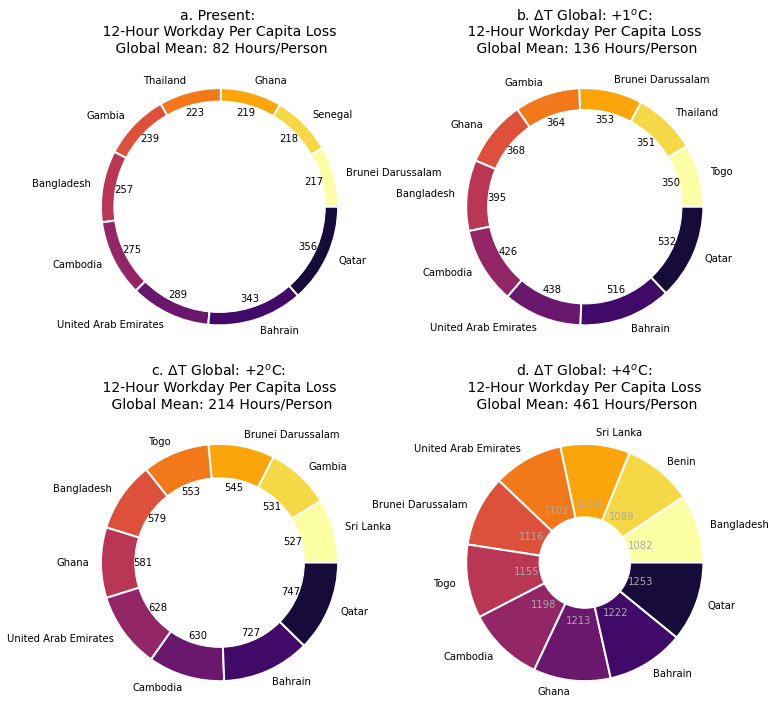

In [8]:
# donut plot of top 10 countries with 12-hour workday labor lost per capita, or mean hours within each country

fig = plt.figure(figsize=(12,12))

if variableindex == 0:
    MaxAmount = 750
else:
    MaxAmount = 50


for gi,gwf in enumerate(gwfs_plot):
    
    laborlost_regridded_countrymaskgrid = vars()['nc_labor_percapita_gwf'+str(gwf)]['hours_lost_'+str(variable)]
    laborlost_regridded_countrymaskgrid = laborlost_regridded_countrymaskgrid.mean(dim='time') #make 20-yr mean
    
    #regrid to country grid scale
    regridder = xe.Regridder(laborlost_regridded_countrymaskgrid, countryfraction, 'bilinear') #'conservative' or 'bilinear'
    laborlost_regridded_countrymaskgrid = regridder(laborlost_regridded_countrymaskgrid)#regrid!
    
    vars()['country_mean_laborlost_'+str(gwf)] = np.zeros([len(countrynames_fraction)])
    for countryindex,country in countrynames_fraction.items():
        vars()['country_mean_laborlost_'+str(gwf)][countryindex] = np.nanmean(np.reshape(laborlost_regridded_countrymaskgrid.where(countryfraction[countryindex,:,:]>0).values,[len(LAT_countries)*len(LON_countries),1]))

    country_sum_hourslost_sortindex = np.argsort(vars()['country_mean_laborlost_'+str(gwf)])
    countrynames_fraction_sortedbywagelost = countrynames_fraction[country_sum_hourslost_sortindex]

    
    ax = plt.subplot(2,2,gi+1)
    
    # try a donut plot
    colors_donuts = plt.cm.inferno_r(np.linspace(0,1,1+len(countrynames_fraction_sortedbywagelost[183:194])))
    names = countrynames_fraction_sortedbywagelost[183:194]
    size = vars()['country_mean_laborlost_'+str(gwf)][country_sum_hourslost_sortindex][183:194]
    def autopct_format(size):
        def my_format(pct):
            total = sum(size)
            val = int(round(pct*total/100.0))
            return '{v:d}'.format(v=val)
        return my_format
    #explode = (0.2, 0.2, 0.2, 0.1, 0.1, 0, 0, 0, 0, 0)
    # Create a circle at the center of the plot
    TopCountryMean = np.nanmean(vars()['country_mean_laborlost_'+str(gwf)][country_sum_hourslost_sortindex][180:194])
    AllCountryMean = np.nanmean(vars()['country_mean_laborlost_'+str(gwf)][country_sum_hourslost_sortindex][:]) #all countries
    radiussize = 1-(AllCountryMean/MaxAmount)
    my_circle = plt.Circle( (0,0), radiussize, color='white')
    if radiussize < 0.5:
        _, _, autotexts = plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize+0.11, colors=colors_donuts,wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' })
        for autotext in autotexts:
            autotext.set_color('darkgrey')
    else:
        plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize-0.07, colors=colors_donuts,wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' })

    p = plt.gcf()
    
    p.gca().add_artist(my_circle)
    if gwf == 0:
        plt.title(str(letterlabels[gi])+' Present: \n '+str(timeofday[variableindex])+' Per Capita Loss \n Global Mean: '+str(int(np.round(AllCountryMean,0)))+ ' Hours/Person',fontsize=14)
    else:
        plt.title(str(letterlabels[gi])+' $\Delta$T Global: +'+str(gwf)+'$^o$C: \n '+str(timeofday[variableindex])+' Per Capita Loss \n Global Mean: '+str(int(np.round(AllCountryMean,0)))+ ' Hours/Person',fontsize=14)
    
    print('GWF:',str(gwf),'C:',int(np.round(AllCountryMean,0)),' Hours')


#fig.savefig( 'Figure5_CountryLevel_PerCapitaLaborLost',dpi=300,bbox_inches='tight')
#plt.savefig( 'Figure5_CountryLevel_PerCapitaLaborLost.eps', format='eps')

## now plot donut plot of the worker productivity (2017PPP$) losses in ag + industry/construction based on ag/construction worker contributions to each country's GDP

For Global Warming Relative to Present of: 0 C: 670  there are losses of Billion 2017 PPP$
For Global Warming Relative to Present of: 1 C: 1069  there are losses of Billion 2017 PPP$
For Global Warming Relative to Present of: 2 C: 1626  there are losses of Billion 2017 PPP$
For Global Warming Relative to Present of: 4 C: 3286  there are losses of Billion 2017 PPP$


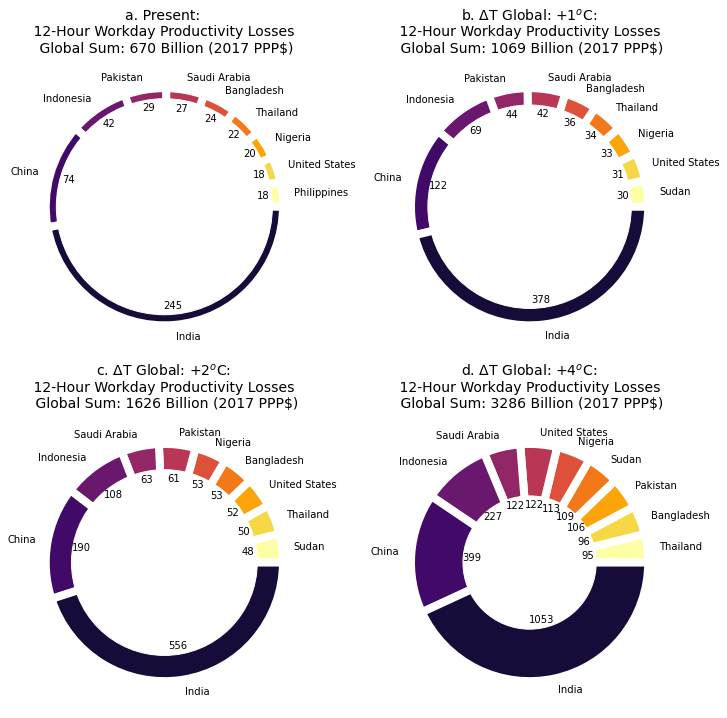

In [16]:

MaxAmount = 7.5e3

fig = plt.figure(figsize=(12,12))

gwfs_plot = [0,1,2,4]

for gi,gwf in enumerate(gwfs_plot):
    

    GDPAgConstrPPP = nc_prod['annual_productivity_lost_'+str(variable)+'_'+str(strings_warmingfactors[gi])]
    
    country_sum_wageslost = np.zeros([len(countrynames_fraction)])
    for countryindex,country in countrynames_fraction.items():
        country_sum_wageslost[countryindex] = (xr.ufuncs.ceil(countryfraction_nan[countryindex,:,:]) * GDPAgConstrPPP).sum(dim=('lat','lon'))
    country_sum_wageslost_sortindex = np.argsort(country_sum_wageslost)
    countrynames_fraction_sortedbywagelost = countrynames_fraction[country_sum_wageslost_sortindex]
    
    ax = plt.subplot(2,2,gi+1)
    
    # try a donut plot
    colors_donuts = plt.cm.inferno_r(np.linspace(0,1,1+len(countrynames_fraction_sortedbywagelost[183:194])))
    names = countrynames_fraction_sortedbywagelost[183:194]
    size = country_sum_wageslost[country_sum_wageslost_sortindex][183:194]/1e9
    def autopct_format(size):
        def my_format(pct):
            total = sum(size)
            val = int(round(pct*total/100.0))
            return '{v:d}'.format(v=val)
        return my_format
    TopCountrySum = np.nansum(country_sum_wageslost[country_sum_wageslost_sortindex][180:194]/1e9)
    AllCountrySum = (GDPAgConstrPPP.sum(dim='lat').sum(dim='lon')).values/1e9 #all countries
    radiussize = 1-(AllCountrySum/MaxAmount)
    my_circle = plt.Circle( (0,0), radiussize, color='white')
    if radiussize < 0.5:
        _, _, autotexts = plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize+0.1, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })
        for autotext in autotexts:
            autotext.set_color('lightgrey')
    else:
        plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize-0.07, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    if gwf == 0:
        plt.title(str(letterlabels[gi])+' Present: \n '+str(timeofday[variableindex])+' Productivity Losses \n Global Sum: '+str(int(np.round(AllCountrySum,0)))+ ' Billion (2017 PPP$)',fontsize=14)
    else:
        plt.title(str(letterlabels[gi])+' $\Delta$T Global: +'+str(gwf)+'$^o$C: \n '+str(timeofday[variableindex])+' Productivity Losses \n Global Sum: '+str(int(np.round(AllCountrySum,0)))+ ' Billion (2017 PPP$)',fontsize=14)    
        
    print('For Global Warming Relative to Present of',str(gwf),'C:',int(np.round(AllCountrySum,0)),' there are losses of Billion 2017 PPP$')
    
#fig.savefig('Figure_S13'),dpi=300,bbox_inches='tight')